In [1]:
!pip install -qU torch_snippets

In [2]:
from torch_snippets import *
from PIL import Image
import cv2
import numpy as np
import torch
import torchvision
from torch.utils.data import Dataset, DataLoader
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.ops import nms
import pandas as pd
import glob
from sklearn.model_selection import train_test_split
# torchvision: A library that provides datasets, models, and image transformations for computer vision
# torch.utils.data: A module in PyTorch that provides utilities for loading data
# Importing Faster R-CNN model and utilities from torchvision
# sklearn.model_selection: A module in scikit-learn that provides tools for splitting datasets into train and test sets

In [4]:
IMG_ROOT = 'data/training_images'
device = 'cuda' if torch.cuda.is_available() else 'cpu'
# Check if a CUDA-enabled GPU is available; if not, use the CPU
df =pd.read_csv('data/train_solution_bounding_boxes (1).csv')
# Read the CSV file containing bounding box annotations into a pandas DataFrame
df = df.rename(columns={'image' : 'ImageID'})
df


,ImageID,xmin,ymin,xmax,ymax
0,vid_4_1000.jpg,281.259045,187.035071,327.727931,223.225547
1,vid_4_10000.jpg,15.163531,187.035071,120.329957,236.430180
2,vid_4_10040.jpg,239.192475,176.764801,361.968162,236.430180
3,vid_4_10020.jpg,496.483358,172.363256,630.020260,231.539575
4,vid_4_10060.jpg,16.630970,186.546010,132.558611,238.386422
...,...,...,...,...,...
554,vid_4_9860.jpg,0.000000,198.321729,49.235251,236.223284
555,vid_4_9880.jpg,329.876184,156.482351,536.664239,250.497895
556,vid_4_9900.jpg,0.000000,168.295823,141.797524,239.176652
557,vid_4_9960.jpg,487.428988,172.233646,616.917699,228.839864


In [5]:
# Split the unique image IDs from the DataFrame into training and validation sets
# Using 10% of the data for validation, with a fixed random state for reproducibility
trn_ids, val_ids = train_test_split(df.ImageID.unique(), test_size=0.1, random_state=99)
trn_df, val_df = df[df['ImageID'].isin(trn_ids)], df[df['ImageID'].isin(val_ids)]
len(trn_df), len(val_df)
# Print the number of rows in the training and validation DataFrames

(501, 58)

In [6]:
label2target = {'background': 0 , 'car' : 1  }
target2label = { t: l for l,t in  label2target.items()}
background_class = label2target['background']
num_classes = len(label2target)
# Determine the number of classes by finding the length of the label2target dictionary

In [7]:
def preprocess_image(img):
    img = torch.tensor(img).permute(2,0,1)
    return img.to(device).float()

In [8]:
class OpenDataset(Dataset):
    def __init__(self, df, image_dir):
        self.w, self.h = 224, 224
        self.image_dir = image_dir
        self.files = glob.glob(self.image_dir+'/*')
        self.df = df.copy()
        self.image_infos = df.ImageID.unique()
        
    def __getitem__(self, ix):
        # load images and masks
        image_id = self.image_infos[ix]
        img_path = find(image_id, self.files)
        # Find the path to the image file using the image ID
        img = Image.open(img_path).convert("RGB")
        data = self.df[self.df['ImageID'] == image_id]
        H, W , _ = np.array(img).shape
        data.loc[:, ['xmin', 'ymin', 'xmax', 'ymax']] /= [W, H, W, H]
        # Normalize the bounding box coordinates by dividing by the width and height
        img = np.array(img.resize((self.w, self.h), resample=Image.BILINEAR))/255.
        # Resize the image to the target dimensions and normalize pixel values
        labels = ['car'] * len(data)
        data = data[['xmin','ymin','xmax','ymax']].values
        data[:,[0,2]] *= self.w
        data[:,[1,3]] *= self.h
        boxes = data.astype(np.uint32).tolist() 
        # Create the target dictionary to store bounding boxes and labels
        target = {}
        target["boxes"] = torch.Tensor(boxes).float()
        target["labels"] = torch.Tensor([label2target[i] for i in labels]).long()
        img = preprocess_image(img)
        return img, target
    def collate_fn(self, batch):
        return tuple(zip(*batch)) 
    # Collate function to combine a list of samples into a batch

    def __len__(self):
        return len(self.image_infos)
    # Return the number of unique images in the dataset

In [9]:
train_ds = OpenDataset(trn_df, IMG_ROOT)
# Create an instance of the OpenDataset class for the training dataset
# Using the training DataFrame and image directory
test_ds = OpenDataset(val_df , IMG_ROOT)
# Create an instance of the OpenDataset class for the validation dataset
# Using the validation DataFrame and image directory

train_loader = DataLoader(train_ds, batch_size=4, collate_fn=train_ds.collate_fn, drop_last=True)
test_loader = DataLoader(test_ds, batch_size=4, collate_fn=test_ds.collate_fn, drop_last=True)
# Create a DataLoader for the training dataset
# - Uses the train_ds dataset
# - Batch size of 4
# - Uses the custom collate function defined in the dataset class
# - drop_last=True ensures that if the number of samples is not divisible by the batch size, the last incomplete batch is dropped.

In [10]:
def get_model():
    model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained = True)
    in_features = model.roi_heads.box_predictor.cls_score.in_features
     # Replace the pre-trained box predictor with a new one that has the correct number of classes
    # FastRCNNPredictor takes the number of input features and the number of classes as arguments
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features # number of input channels
                                                    , num_classes)
    return model

In [11]:
def train_batch(inputs, model, optimizer):
    model.train()
    input, targets = inputs
    input = list(image.to(device) for image in input)
    targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
    optimizer.zero_grad()
    # Zero the gradients of the optimizer to avoid accumulation
    losses = model(input, targets)
    loss = sum(loss for loss in losses.values())
    loss.backward()
    optimizer.step()
    return loss, losses

@torch.no_grad() # this will disable gradient computation in the function below
def validate_batch(inputs, model):
    model.train() # to obtain the losses, model needs to be in train mode only. # #Note that here we are not defining the model's forward method 
    #and hence need to work per the way the model class is defined
    input, targets = inputs
    input = list(image.to(device) for image in input)
    targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

    optimizer.zero_grad()
    losses = model(input, targets)
    loss = sum(loss for loss in losses.values())
    return loss, losses

In [12]:
model = get_model().to(device)
optimizer = torch.optim.SGD(model.parameters(), lr=0.005,
                            momentum=0.9, weight_decay=0.0005)
# Set up the optimizer, using Stochastic Gradient Descent (SGD) with:
# - Learning rate (lr) of 0.005
# - Momentum of 0.9 to help accelerate gradients vectors in the right directions
# - Weight decay (L2 penalty) of 0.0005 to prevent overfitting
n_epochs = 10
log = Report(n_epochs)

C:\Users\rishi\AppData\Roaming\Python\Python312\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\rishi\AppData\Roaming\Python\Python312\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=FasterRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [13]:
# Loop through each epoch
for epoch in range(n_epochs):
    # Get the number of batches in the training DataLoader
    _n = len(train_loader)
    
    # Loop through each batch in the training DataLoader
    for ix, inputs in enumerate(train_loader):
        # Perform a training step and get the loss and individual losses
        loss, losses = train_batch(inputs, model, optimizer)
        
        # Extract specific losses from the dictionary
        loc_loss, regr_loss, loss_objectness, loss_rpn_box_reg = \
            [losses[k] for k in ['loss_classifier', 'loss_box_reg', 'loss_objectness', 'loss_rpn_box_reg']]
        
        # Calculate the position for logging
        pos = (epoch + (ix + 1) / _n)
        
        # Record the losses in the log
        log.record(pos, trn_loss=loss.item(), trn_loc_loss=loc_loss.item(), 
                   trn_regr_loss=regr_loss.item(), trn_objectness_loss=loss_objectness.item(),
                   trn_rpn_box_reg_loss=loss_rpn_box_reg.item(), end='\r')

    # Get the number of batches in the validation DataLoader
    _n = len(test_loader)
    
    # Loop through each batch in the validation DataLoader
    for ix, inputs in enumerate(test_loader):
        # Perform a validation step and get the loss and individual losses
        loss, losses = validate_batch(inputs, model)
        
        # Extract specific losses from the dictionary
        loc_loss, regr_loss, loss_objectness, loss_rpn_box_reg = \
            [losses[k] for k in ['loss_classifier', 'loss_box_reg', 'loss_objectness', 'loss_rpn_box_reg']]
        
        # Calculate the position for logging
        pos = (epoch + (ix + 1) / _n)
        
        # Record the losses in the log
        log.record(pos, val_loss=loss.item(), val_loc_loss=loc_loss.item(), 
                   val_regr_loss=regr_loss.item(), val_objectness_loss=loss_objectness.item(),
                   val_rpn_box_reg_loss=loss_rpn_box_reg.item(), end='\r')
    
    # Report average losses every n_epochs/5 epochs
    if (epoch + 1) % (n_epochs // 5) == 0:
        log.report_avgs(epoch + 1)

     

EPOCH: 2.000  trn_loss: 0.147  trn_regr_loss: 0.108  val_loss: 0.161  val_loc_loss: 0.044  trn_loc_loss: 0.036  val_rpn_box_reg_loss: 0.003  val_objectness_loss: 0.001  val_regr_loss: 0.113  trn_rpn_box_reg_loss: 0.002  trn_objectness_loss: 0.001  (2449.97s - 9799.88s remaining)
EPOCH: 4.000  trn_loss: 0.117  trn_regr_loss: 0.086  val_loss: 0.154  val_loc_loss: 0.040  trn_loc_loss: 0.029  val_rpn_box_reg_loss: 0.002  val_objectness_loss: 0.002  val_regr_loss: 0.109  trn_rpn_box_reg_loss: 0.001  trn_objectness_loss: 0.000  (4635.85s - 6953.78s remaining)
EPOCH: 6.000  trn_loss: 0.100  trn_regr_loss: 0.073  val_loss: 0.186  val_loc_loss: 0.054  trn_loc_loss: 0.025  val_rpn_box_reg_loss: 0.003  val_objectness_loss: 0.001  val_regr_loss: 0.128  trn_rpn_box_reg_loss: 0.001  trn_objectness_loss: 0.000  (6848.82s - 4565.88s remaining)
EPOCH: 8.000  trn_loss: 0.102  trn_regr_loss: 0.076  val_loss: 0.173  val_loc_loss: 0.048  trn_loc_loss: 0.024  val_rpn_box_reg_loss: 0.003  val_objectness_loss

In [14]:
def decode_output(output):
    # Convert bounding box coordinates from tensor to numpy array and cast to unsigned 16-bit integers
    bbs = output['boxes'].cpu().detach().numpy().astype(np.uint16)
    
    # Convert labels from tensor to numpy array and map them back to the label names
    labels = np.array([target2label[i] for i in output['labels'].cpu().detach().numpy()])
    
    # Convert confidence scores from tensor to numpy array
    confs = output['scores'].cpu().detach().numpy()
    
    # Perform Non-Maximum Suppression (NMS) to filter overlapping bounding boxes
    # 0.05 is the IoU threshold for NMS
    ixs = nms(torch.tensor(bbs.astype(np.float32)), torch.tensor(confs), 0.05)
    
    # Filter the bounding boxes, confidence scores, and labels based on the NMS indices
    bbs, confs, labels = [tensor[ixs] for tensor in [bbs, confs, labels]]
    
    # Ensure the outputs are arrays if there is only one detection
    if len(ixs) == 1:
        bbs, confs, labels = [np.array([tensor]) for tensor in [bbs, confs, labels]]
    
    # Convert the bounding boxes, confidence scores, and labels to lists and return them
    return bbs.tolist(), confs.tolist(), labels.tolist()


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..255.0].


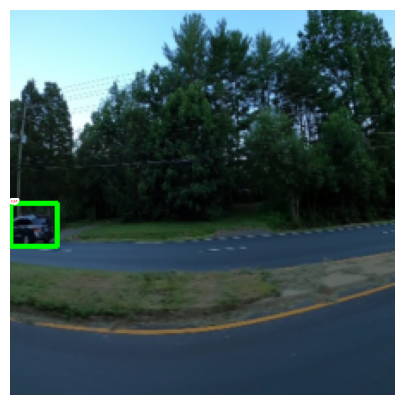

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..255.0].


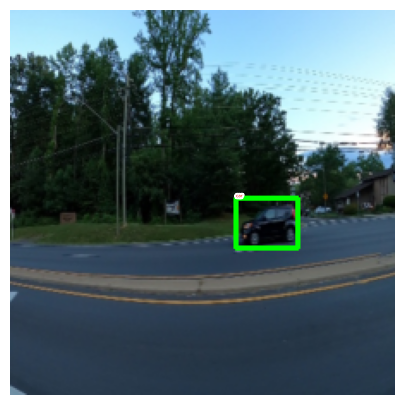

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..255.0].


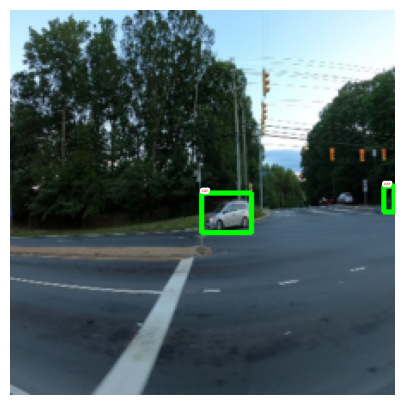

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..255.0].


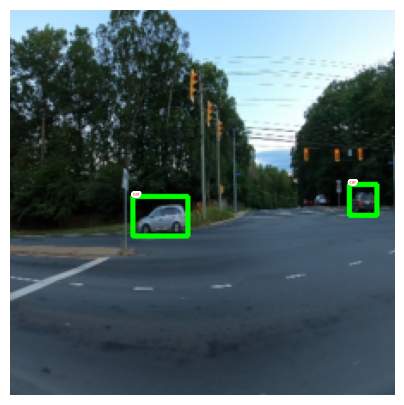

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..255.0].


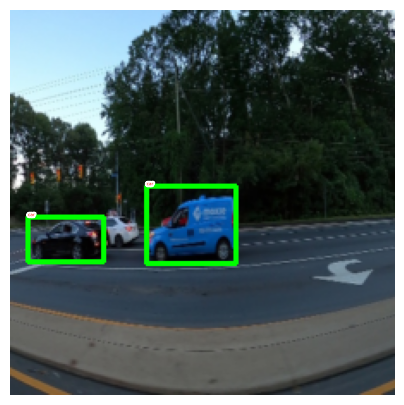

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..255.0].


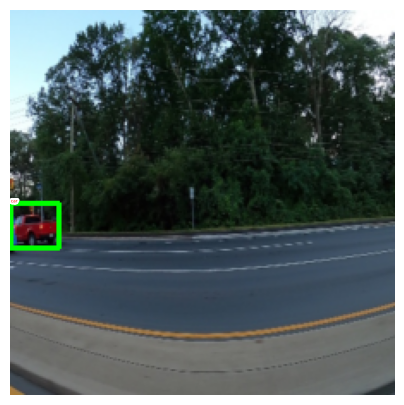

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..255.0].


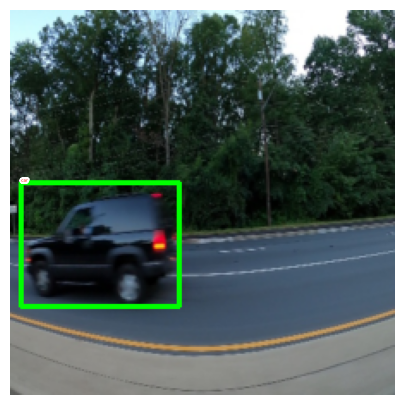

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..255.0].


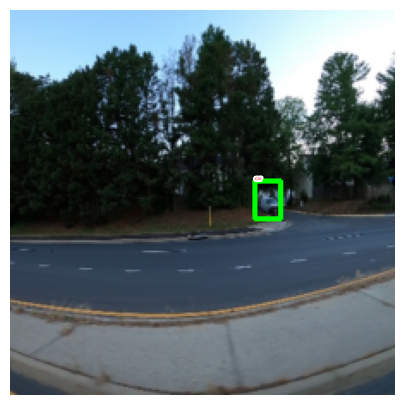

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..255.0].


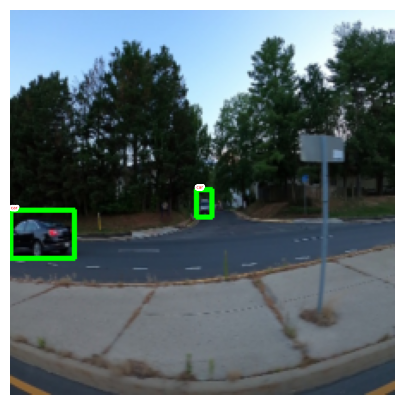

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..255.0].


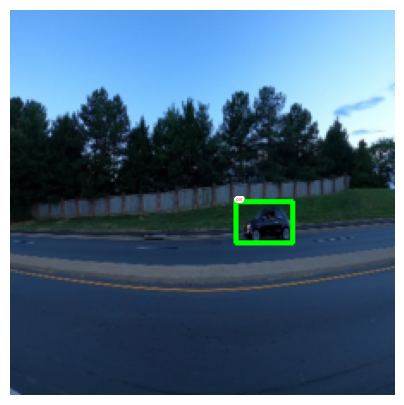

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..255.0].


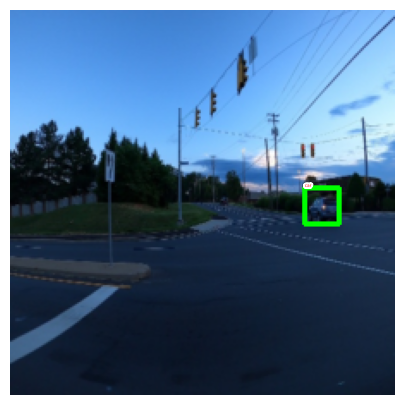

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..255.0].


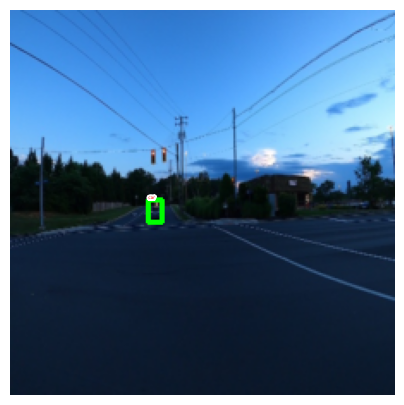

In [15]:
# Set the model to evaluation mode
model.eval()

# Loop through the batches in the test DataLoader
for ix, (images, targets) in enumerate(test_loader):
    # Break the loop after processing the first 3 batches
    if ix == 3:
        break
    
    # List comprehension to keep the images as they are
    images = [im for im in images]
    
    # Get the model's output for the batch of images
    outputs = model(images)
    
    # Loop through the outputs for each image in the batch
    for ix, output in enumerate(outputs):
        # Decode the model output to get bounding boxes, confidence scores, and labels
        bbs, confs, labels = decode_output(output)
        
        # Create a list of information strings combining labels and confidence scores
        info = [f'{l}@{c:.2f}' for l, c in zip(labels, confs)]
        
        # Display the image with bounding boxes and labels
        show(images[ix].cpu().permute(1, 2, 0), bbs=bbs, texts=labels, sz=5)
